<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/nguwijy/deep_branching_with_domain/blob/master/notebooks/deep_navier_stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Imports & basic configuration

In [1]:
import os
import sys
# install the package if not yet installed
try:
    from branch.branch import Net
except:
    !python -m pip install git+https://github.com/nguwijy/deep_branching_with_domain.git
    from branch.branch import Net
import numbers
import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import cm 
import time
import logging
from pynverse import inversefunc
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# perfect reproducibility is not guaranteed with different version of torch
#
print(f"torch version: {torch.__version__}")

torch version: 1.11.0+cu113


In [3]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Mon Oct 24 13:35:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.76       Driver Version: 515.76       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:07:00.0  On |                  N/A |
|  0%   55C    P8    33W / 350W |    273MiB / 12288MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

# Navier-Stokes equation
$$
\begin{cases}
  \displaystyle
  \partial_t u_i(t,x) + \frac{\nu}{2} \Delta u_i(t,x) = \partial_{1_i} p(t,x) + \sum\limits_{j=0}^{d-1} u_j(t,x) \partial_{1_j} u_i(t,x), \quad i = 0,\ldots , d-1,
  \\
u_i(T,x) = \phi_i (x),
  \\
  \displaystyle
  \Delta u_{-1}(t, x) = -\sum\limits_{i,j=0}^{d-1} \partial_{1_j} u_i(t,x) \partial_{1_i} u_j(t,x),
   \\
\sum\limits_{i = 0}^{d - 1} \partial_{1_i} u_i(t, x) = 0, \quad (t,x) = (t,x_1, \ldots, x_d) \in [0,T] \times \mathbb{R}^d.
\end{cases}
$$

## 2-dimensional Taylor-Green vortex
$$
\begin{cases}
  \displaystyle
  u_1(t, x) = - \cos(x_1) \sin(x_2) e^{-\nu (T - t)},
  \\
  u_2(t, x) = \sin(x_1) \cos(x_2) e^{-\nu (T - t)},
  \\
  \displaystyle
  u_0(t, x) = -\frac{1}{4} \left(\cos(2x_1) + \cos(2x_2)\right) e^{-2\nu (T - t)} + c,
\end{cases}
$$
$x=(x_1,x_2) \in [0,2\pi]^2$.

In [4]:
# function definition
deriv_map = np.array(
    [
        [1, 0],  # for nabla p
        [0, 1],
        [0, 0],  # for u
        [0, 0],
        [1, 0],  # for nabla u1
        [0, 1],
        [1, 0],  # for nabla u2
        [0, 1],
    ]
)
zeta_map = np.array([-1, -1, 0, 1, 0, 0, 1, 1])
deriv_condition_deriv_map = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1])
_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return -torch.cos(x[0]) * torch.sin(x[1])
    else:
        return torch.sin(x[0]) * torch.cos(x[1])

def exact_example(t, x, T, coordinate, nu):
    if coordinate == 0:
        return -np.cos(x[0]) * np.sin(x[1]) * np.exp(-nu * (T - t))
    else:
        return np.sin(x[0]) * np.cos(x[1]) * np.exp(-nu * (T - t))

def exact_example_u_tensor(tx, coordinate, T, nu):
    if coordinate == 0:
        return -torch.cos(tx[1]) * torch.sin(tx[2]) * torch.exp(-nu * (T - tx[0]))
    else:
        return torch.sin(tx[1]) * torch.cos(tx[2]) * torch.exp(-nu * (T - tx[0]))

def exact_example_p_tensor(tx):
    return (
        -1/ 4
        * torch.exp(-2 * nu * (T - tx[0]))
        * (torch.cos(2 * tx[1]) + torch.cos(2 * tx[2]))
    )

problem_name = "taylor_green_2d"
t_lo, x_lo, x_hi = 0., 0, 4 * math.pi

### T = .25, nu = 2

In [5]:
T, nu = .25, 2

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
    fix_t_dim=False,
    save_for_best_model=False,
    outlier_multiplier=10,
    overtrain_rate_for_p=0.1,
)
model.train_and_eval()

Logs are saved in /home/oem/deep_branching_with_domain/notebooks/logs/20221024-012851-taylor_green_2d-T0.25-nu2
Patch 0: generation of p samples take 733.4340443611145 seconds.
Patch  0: epoch    0 with loss 2.93E+00
Patch  0: epoch  500 with loss 1.88E-02
Patch  0: epoch 1000 with loss 5.75E-03
Patch  0: epoch 1500 with loss 1.34E-03
Patch  0: epoch 2000 with loss 1.14E-03
Patch  0: epoch 2500 with loss 1.12E-03
Patch  0: epoch 3000 with loss 1.09E-03
Patch  0: epoch 3500 with loss 1.05E-03
Patch  0: epoch 4000 with loss 1.01E-03
Patch  0: epoch 4500 with loss 9.57E-04
Patch  0: epoch 5000 with loss 8.98E-04
Patch  0: epoch 5500 with loss 8.33E-04
Patch  0: epoch 6000 with loss 7.61E-04
Patch  0: epoch 6500 with loss 6.85E-04
Patch  0: epoch 7000 with loss 6.06E-04
Patch  0: epoch 7500 with loss 5.28E-04
Patch  0: epoch 8000 with loss 4.53E-04
Patch  0: epoch 8500 with loss 3.84E-04
Patch  0: epoch 9000 with loss 3.24E-04
Patch  0: epoch 9500 with loss 2.75E-04
Patch  0: epoch 9999 wi

The error as in Lejay is calculated as follows.
$\hat{e}_0(t_k)$
& 2.55E-03 & 2.03E-03 & 1.67E-03 & 1.70E-03 & 1.69E-03 & 1.64E-03 & 1.51E-03 & 1.97E-03 & 2.63E-03 & 3.42E-03 & --- \\
$\hat{e}_1(t_k)$
& 2.51E-03 & 2.20E-03 & 2.44E-03 & 2.53E-03 & 2.55E-03 & 2.48E-03 & 2.31E-03 & 2.13E-03 & 3.55E-03 & 6.03E-03 & --- \\
$\hat{e}(t_k)$
& 4.16E-03 & 4.04E-03 & 3.74E-03 & 3.20E-03 & 2.89E-03 & 2.88E-03 & 2.76E-03 & 3.68E-03 & 5.52E-03 & 8.50E-03 & --- \\
\hline

The relative L2 error of u (erru) is calculated as follows.
erru($t_k$)
& 5.11E-02 & 4.32E-02 & 3.96E-02 & 3.79E-02 & 3.66E-02 & 3.46E-02 & 3.18E-02 & 2.87E-02 & 2.77E-02 & 3.28E-02 & --- \\

The relative L2 error of gradient of u (errgu) is calculated as follows.
errgu($t_k$)
& 7.86E-02 & 6.80E-02 & 6.17E-02 & 5.80E-02 & 5.56E-02 & 5.37E-02 & 5.19E-02 & 5.10E-02 & 5.23E-02 & 5.78E-02 & --- \\

The absolute divergence of u (errdivu) is calculated as follows.
errdivu($t_k$)
& 1.25E-01 & 9.43E-02 & 7.89E-02 & 7.41E-02 & 7.51E-02 & 7.7

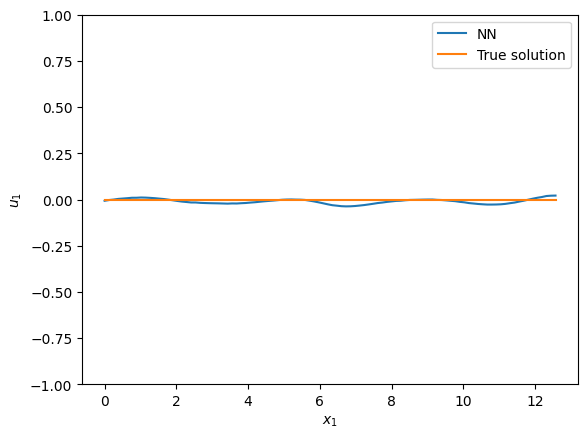

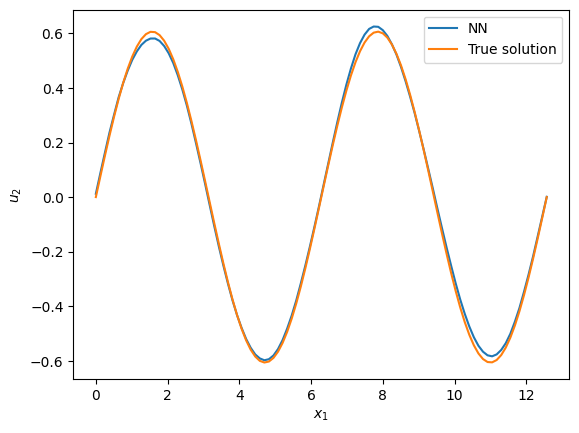

In [6]:
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=4*126+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu), exclude_terminal=True, ylim=(-1, 1))

taylor_green_reuse_checkpoint = model.working_dir

[Link to log directory:](logs/20220601-222808-taylor_green_2d-T0.25-nu2)

### T = 1, nu = .2

In [7]:
T, nu = 1, .2

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
    fix_t_dim=False,
    save_for_best_model=False,
    outlier_multiplier=10,
    overtrain_rate_for_p=0.1,
    continue_from_checkpoint=taylor_green_reuse_checkpoint,
)
model.train_and_eval()

Logs are saved in /home/oem/deep_branching_with_domain/notebooks/logs/20221024-021811-taylor_green_2d-T1-nu0.2
Patch 0: generation of u samples take 923.6519436836243 seconds.
Patch  0: epoch    0 with loss 2.62E-01
Patch  0: epoch  500 with loss 3.58E-03
Patch  0: epoch 1000 with loss 5.67E-04
Patch  0: epoch 1500 with loss 4.70E-04
Patch  0: epoch 2000 with loss 4.23E-04
Patch  0: epoch 2500 with loss 4.20E-04
Patch  0: epoch 3000 with loss 4.13E-04
Patch  0: epoch 3500 with loss 4.05E-04
Patch  0: epoch 4000 with loss 3.95E-04
Patch  0: epoch 4500 with loss 3.83E-04
Patch  0: epoch 5000 with loss 3.69E-04
Patch  0: epoch 5500 with loss 3.52E-04
Patch  0: epoch 6000 with loss 3.34E-04
Patch  0: epoch 6500 with loss 3.14E-04
Patch  0: epoch 7000 with loss 2.92E-04
Patch  0: epoch 7500 with loss 2.68E-04
Patch  0: epoch 8000 with loss 2.44E-04
Patch  0: epoch 8500 with loss 2.22E-04
Patch  0: epoch 9000 with loss 1.99E-04
Patch  0: epoch 9500 with loss 1.79E-04
Patch  0: epoch 9999 wit

The error as in Lejay is calculated as follows.
$\hat{e}_0(t_k)$
& 1.10E-03 & 7.48E-04 & 6.07E-04 & 5.44E-04 & 4.80E-04 & 4.24E-04 & 3.81E-04 & 3.23E-04 & 3.78E-04 & 5.17E-04 & --- \\
$\hat{e}_1(t_k)$
& 6.09E-04 & 4.54E-04 & 5.70E-04 & 5.84E-04 & 5.74E-04 & 6.25E-04 & 6.28E-04 & 6.03E-04 & 7.06E-04 & 9.14E-04 & --- \\
$\hat{e}(t_k)$
& 1.19E-03 & 1.02E-03 & 8.91E-04 & 8.52E-04 & 7.87E-04 & 7.53E-04 & 7.15E-04 & 7.04E-04 & 8.45E-04 & 1.10E-03 & --- \\
\hline

The relative L2 error of u (erru) is calculated as follows.
erru($t_k$)
& 1.69E-02 & 1.39E-02 & 1.33E-02 & 1.33E-02 & 1.32E-02 & 1.29E-02 & 1.26E-02 & 1.26E-02 & 1.31E-02 & 1.47E-02 & --- \\

The relative L2 error of gradient of u (errgu) is calculated as follows.
errgu($t_k$)
& 3.61E-02 & 3.19E-02 & 2.99E-02 & 2.92E-02 & 2.91E-02 & 2.93E-02 & 2.99E-02 & 3.10E-02 & 3.28E-02 & 3.60E-02 & --- \\

The absolute divergence of u (errdivu) is calculated as follows.
errdivu($t_k$)
& 7.84E-02 & 5.75E-02 & 4.99E-02 & 4.88E-02 & 4.89E-02 & 4.8

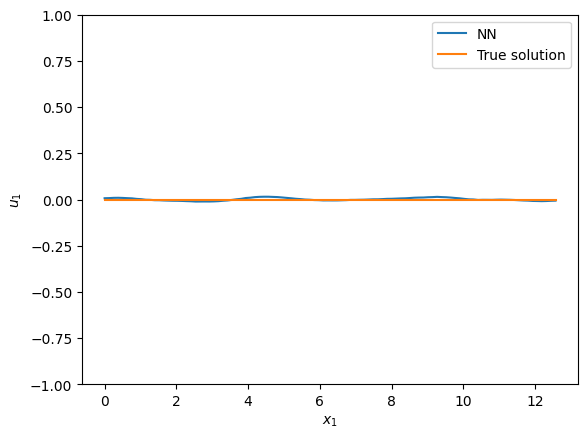

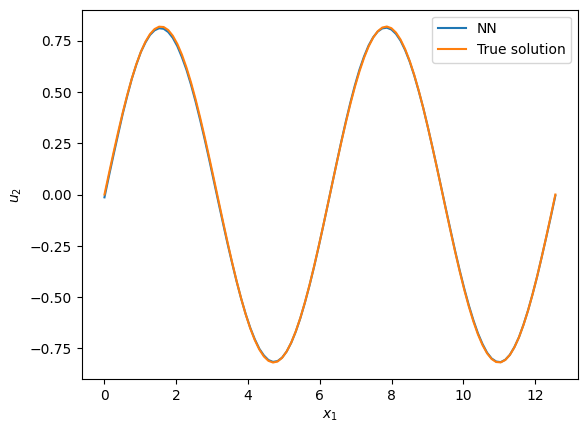

In [8]:
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=4*126+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu), exclude_terminal=True, ylim=(-1, 1))

[Link to log directory:](logs/20220601-230945-taylor_green_2d-T1-nu0.2)

### T = 10, nu = .02

In [9]:
T, nu = 10, .02

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
    fix_t_dim=False,
    save_for_best_model=False,
    outlier_multiplier=10,
    overtrain_rate_for_p=0.1,
    continue_from_checkpoint=taylor_green_reuse_checkpoint,
)
model.train_and_eval()

Logs are saved in /home/oem/deep_branching_with_domain/notebooks/logs/20221024-024025-taylor_green_2d-T10-nu0.02
Patch 0: generation of u samples take 927.2621245384216 seconds.
Patch  0: epoch    0 with loss 9.40E-01
Patch  0: epoch  500 with loss 2.77E-03
Patch  0: epoch 1000 with loss 8.08E-03
Patch  0: epoch 1500 with loss 1.75E-03
Patch  0: epoch 2000 with loss 1.72E-03
Patch  0: epoch 2500 with loss 1.70E-03
Patch  0: epoch 3000 with loss 1.70E-03
Patch  0: epoch 3500 with loss 1.69E-03
Patch  0: epoch 4000 with loss 1.69E-03
Patch  0: epoch 4500 with loss 1.69E-03
Patch  0: epoch 5000 with loss 1.67E-03
Patch  0: epoch 5500 with loss 1.69E-03
Patch  0: epoch 6000 with loss 1.64E-03
Patch  0: epoch 6500 with loss 1.61E-03
Patch  0: epoch 7000 with loss 1.56E-03
Patch  0: epoch 7500 with loss 1.53E-03
Patch  0: epoch 8000 with loss 1.49E-03
Patch  0: epoch 8500 with loss 1.50E-03
Patch  0: epoch 9000 with loss 1.45E-03
Patch  0: epoch 9500 with loss 1.41E-03
Patch  0: epoch 9999 w

The error as in Lejay is calculated as follows.
$\hat{e}_0(t_k)$
& 2.14E-02 & 1.68E-02 & 1.44E-02 & 1.33E-02 & 1.32E-02 & 1.37E-02 & 1.40E-02 & 1.39E-02 & 1.30E-02 & 1.19E-02 & --- \\
$\hat{e}_1(t_k)$
& 2.46E-02 & 1.84E-02 & 1.50E-02 & 1.41E-02 & 1.40E-02 & 1.38E-02 & 1.36E-02 & 1.33E-02 & 1.20E-02 & 1.14E-02 & --- \\
$\hat{e}(t_k)$
& 2.70E-02 & 1.90E-02 & 1.51E-02 & 1.43E-02 & 1.42E-02 & 1.47E-02 & 1.46E-02 & 1.42E-02 & 1.31E-02 & 1.26E-02 & --- \\
\hline

The relative L2 error of u (erru) is calculated as follows.
erru($t_k$)
& 1.04E-01 & 9.72E-02 & 9.26E-02 & 8.86E-02 & 8.50E-02 & 8.22E-02 & 8.01E-02 & 7.86E-02 & 7.71E-02 & 7.57E-02 & --- \\

The relative L2 error of gradient of u (errgu) is calculated as follows.
errgu($t_k$)
& 1.01E-01 & 9.00E-02 & 8.39E-02 & 8.04E-02 & 7.85E-02 & 7.76E-02 & 7.72E-02 & 7.67E-02 & 7.60E-02 & 7.61E-02 & --- \\

The absolute divergence of u (errdivu) is calculated as follows.
errdivu($t_k$)
& 1.64E-01 & 1.26E-01 & 1.13E-01 & 1.09E-01 & 1.07E-01 & 1.0

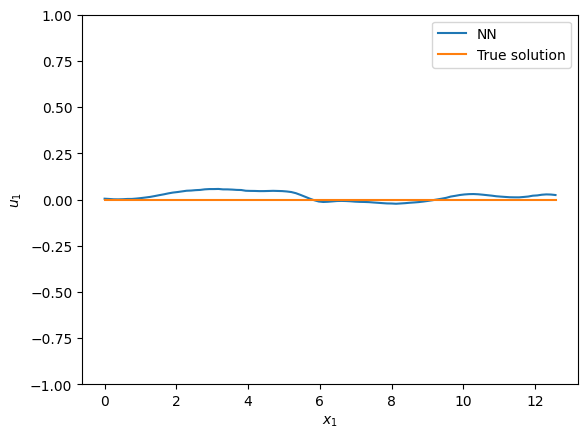

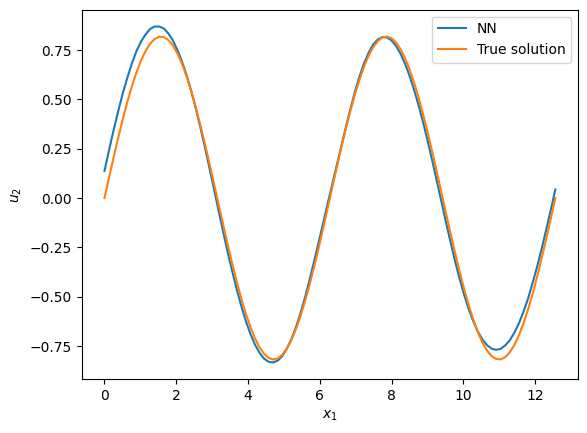

In [10]:
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=4*126+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu), exclude_terminal=True, ylim=(-1, 1))

[Link to log directory:](logs/20220601-233151-taylor_green_2d-T10-nu0.02)

## 3-dimensional ABC flow
$$
\begin{cases}
  \displaystyle
  u_1(t, x) = \left(A \sin(x_3) + C \cos(x_2)\right) e^{-\frac{\nu}{2} (T - t)},
  \\
  u_2(t, x) = \left(B \sin(x_1) + A \cos(x_3)\right) e^{-\frac{\nu}{2} (T - t)},
  \\
  u_3(t, x) = \left(C \sin(x_2) + B \cos(x_1)\right) e^{-\frac{\nu}{2} (T - t)},
  \\
  u_0(t, x) = -\left(AC \sin(x_3) \cos(x_2) + BA \sin(x_1) \cos(x_3) + CB \sin(x_2) \cos(x_1)\right) e^{-\nu (T - t)} + c,
\end{cases}
$$
$x=(x_1,x_2,x_3) \in [0,2\pi]^3$.

In [7]:
A = B = C = 0.5

# function definition
deriv_map = np.array(
    [
        [1, 0, 0],  # for nabla p
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 0],  # for u
        [0, 0, 0],
        [0, 0, 0],
        [1, 0, 0],  # for nabla u1
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],  # for nabla u2
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],  # for nabla u3
        [0, 1, 0],
        [0, 0, 1],
    ]
)
zeta_map = np.array([-1, -1, -1, 0, 1, 2, 0, 0, 0, 1, 1, 1, 2, 2, 2])
deriv_condition_deriv_map = np.array(
    [
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1, 2])

_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return A * torch.sin(x[2]) + C * torch.cos(x[1])
    elif coordinate == 1:
        return B * torch.sin(x[0]) + A * torch.cos(x[2])
    else:
        return C * torch.sin(x[1]) + B * torch.cos(x[0])

def exact_example(t, x, T, coordinate, nu):
    if coordinate == 0:
        return (A * np.sin(x[2]) + C * np.cos(x[1])) * np.exp(-nu / 2 * (T - t))
    elif coordinate == 1:
        return (B * np.sin(x[0]) + A * np.cos(x[2])) * np.exp(-nu / 2 * (T - t))
    else:
        return (C * np.sin(x[1]) + B * np.cos(x[0])) * np.exp(-nu / 2 * (T - t))

def exact_example_u_tensor(tx, coordinate, T, nu):
    if coordinate == 0:
        return (A * torch.sin(tx[3]) + C * torch.cos(tx[2])) * torch.exp(-nu / 2 * (T - tx[0]))
    elif coordinate == 1:
        return (B * torch.sin(tx[1]) + A * torch.cos(tx[3])) * torch.exp(-nu / 2 * (T - tx[0]))
    else:
        return (C * torch.sin(tx[2]) + B * torch.cos(tx[1])) * torch.exp(-nu / 2 * (T - tx[0]))

def exact_example_p_tensor(tx):
    return -torch.exp(-nu * (T - tx[0])) * (
        A * C * torch.sin(tx[3]) * torch.cos(tx[2])
        + B * A * torch.sin(tx[1]) * torch.cos(tx[3])
        + C * B * torch.sin(tx[2]) * torch.cos(tx[1])
    )

problem_name = "abc_3d"
t_lo, x_lo, x_hi = 0., 0, 4 * math.pi

### T = .7, nu = .02

In [12]:
T, nu = .7, .02

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
    fix_t_dim=False,
    save_for_best_model=False,
    outlier_multiplier=10,
    overtrain_rate_for_p=0.1,
)
model.train_and_eval()

Logs are saved in /home/oem/deep_branching_with_domain/notebooks/logs/20221024-030245-abc_3d-T0.7-nu0.02
Patch 0: generation of p samples take 1613.7426211833954 seconds.
Patch  0: epoch    0 with loss 9.94E-01
Patch  0: epoch  500 with loss 3.08E-02
Patch  0: epoch 1000 with loss 1.82E-02
Patch  0: epoch 1500 with loss 4.42E-03
Patch  0: epoch 2000 with loss 3.71E-03
Patch  0: epoch 2500 with loss 3.68E-03
Patch  0: epoch 3000 with loss 3.60E-03
Patch  0: epoch 3500 with loss 3.49E-03
Patch  0: epoch 4000 with loss 3.36E-03
Patch  0: epoch 4500 with loss 3.21E-03
Patch  0: epoch 5000 with loss 3.03E-03
Patch  0: epoch 5500 with loss 2.83E-03
Patch  0: epoch 6000 with loss 2.60E-03
Patch  0: epoch 6500 with loss 2.34E-03
Patch  0: epoch 7000 with loss 2.07E-03
Patch  0: epoch 7500 with loss 1.81E-03
Patch  0: epoch 8000 with loss 1.59E-03
Patch  0: epoch 8500 with loss 1.40E-03
Patch  0: epoch 9000 with loss 1.26E-03
Patch  0: epoch 9500 with loss 1.12E-03
Patch  0: epoch 9999 with los

The error as in Lejay is calculated as follows.
$\hat{e}_0(t_k)$
& 2.56E-03 & 2.44E-03 & 2.29E-03 & 2.12E-03 & 1.97E-03 & 1.84E-03 & 1.70E-03 & 1.53E-03 & 1.62E-03 & 1.80E-03 & --- \\
$\hat{e}_1(t_k)$
& 2.55E-03 & 2.25E-03 & 1.99E-03 & 1.74E-03 & 1.58E-03 & 1.54E-03 & 1.52E-03 & 1.54E-03 & 1.52E-03 & 1.47E-03 & --- \\
$\hat{e}_2(t_k)$
& 1.68E-03 & 1.64E-03 & 1.68E-03 & 1.67E-03 & 1.65E-03 & 1.62E-03 & 1.58E-03 & 1.67E-03 & 1.76E-03 & 1.95E-03 & --- \\
$\hat{e}(t_k)$
& 3.04E-03 & 3.06E-03 & 3.05E-03 & 3.03E-03 & 2.96E-03 & 2.89E-03 & 2.79E-03 & 2.71E-03 & 2.82E-03 & 3.00E-03 & --- \\
\hline

The relative L2 error of u (erru) is calculated as follows.
erru($t_k$)
& 2.12E-02 & 2.01E-02 & 1.95E-02 & 1.91E-02 & 1.89E-02 & 1.88E-02 & 1.88E-02 & 1.90E-02 & 1.94E-02 & 2.02E-02 & --- \\

The relative L2 error of gradient of u (errgu) is calculated as follows.
errgu($t_k$)
& 4.80E-02 & 4.74E-02 & 4.70E-02 & 4.68E-02 & 4.67E-02 & 4.68E-02 & 4.69E-02 & 4.72E-02 & 4.77E-02 & 4.83E-02 & --- \\

The 

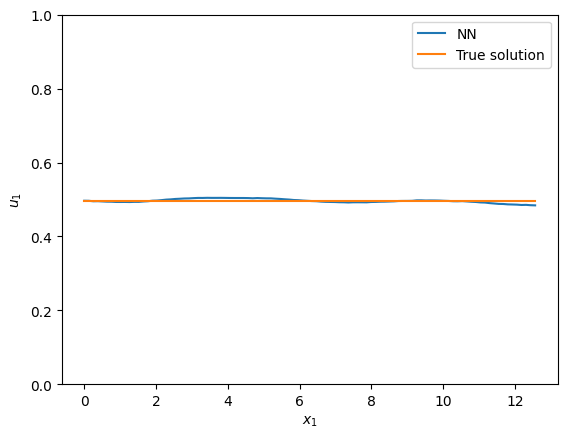

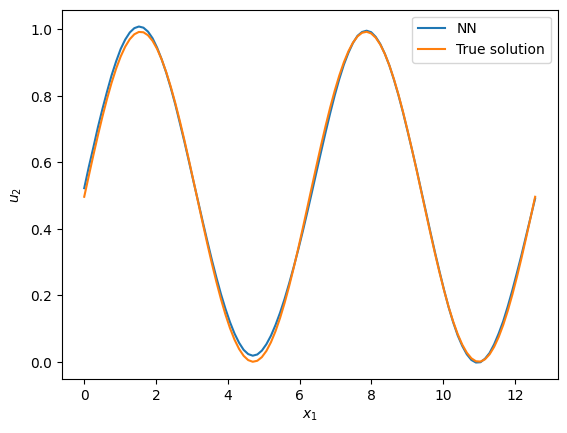

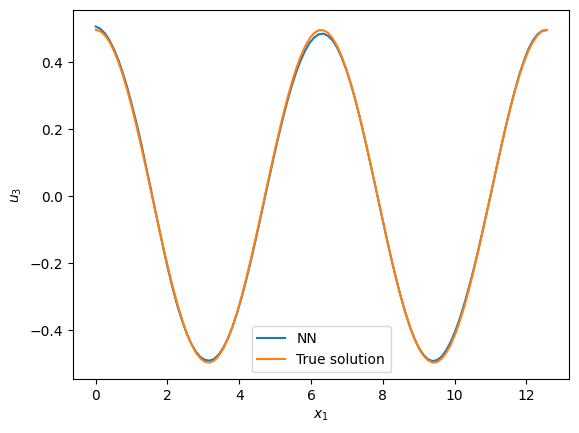

In [9]:
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*45+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu), exclude_terminal=True, ylim=(0, 1))

abc_reuse_checkpoint = model.working_dir

[Link to log directory:](logs/20220601-235327-abc_3d-T0.7-nu0.02)

### T = .7, nu = .0002

In [5]:
T, nu = .7, .0002

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
    fix_t_dim=False,
    save_for_best_model=False,
    outlier_multiplier=10,
    overtrain_rate_for_p=0.1,
    continue_from_checkpoint=abc_reuse_checkpoint,
)
model.train_and_eval()

Logs are saved in /home/oem/deep_branching_with_domain/notebooks/logs/20221024-133631-abc_3d-T0.7-nu0.0002
Patch 0: generation of u samples take 3046.4426193237305 seconds.
Patch  0: epoch    0 with loss 2.87E-04
Patch  0: epoch  500 with loss 1.15E-03
Patch  0: epoch 1000 with loss 6.17E-04
Patch  0: epoch 1500 with loss 4.47E-04
Patch  0: epoch 2000 with loss 4.00E-04
Patch  0: epoch 2500 with loss 3.96E-04
Patch  0: epoch 3000 with loss 3.89E-04
Patch  0: epoch 3500 with loss 3.81E-04
Patch  0: epoch 4000 with loss 3.71E-04
Patch  0: epoch 4500 with loss 3.60E-04
Patch  0: epoch 5000 with loss 3.42E-04
Patch  0: epoch 5500 with loss 3.22E-04
Patch  0: epoch 6000 with loss 3.00E-04
Patch  0: epoch 6500 with loss 2.77E-04
Patch  0: epoch 7000 with loss 2.53E-04
Patch  0: epoch 7500 with loss 2.28E-04
Patch  0: epoch 8000 with loss 2.04E-04
Patch  0: epoch 8500 with loss 1.80E-04
Patch  0: epoch 9000 with loss 1.57E-04
Patch  0: epoch 9500 with loss 1.37E-04
Patch  0: epoch 9999 with l

The error as in Lejay is calculated as follows.
$\hat{e}_0(t_k)$
& 1.22E-03 & 1.15E-03 & 1.09E-03 & 1.03E-03 & 1.01E-03 & 9.49E-04 & 9.53E-04 & 9.93E-04 & 1.06E-03 & 1.10E-03 & --- \\
$\hat{e}_1(t_k)$
& 1.10E-03 & 1.09E-03 & 1.06E-03 & 1.04E-03 & 1.04E-03 & 1.03E-03 & 1.02E-03 & 9.95E-04 & 9.79E-04 & 9.65E-04 & --- \\
$\hat{e}_2(t_k)$
& 1.59E-03 & 1.58E-03 & 1.56E-03 & 1.56E-03 & 1.55E-03 & 1.54E-03 & 1.52E-03 & 1.52E-03 & 1.53E-03 & 1.53E-03 & --- \\
$\hat{e}(t_k)$
& 1.74E-03 & 1.70E-03 & 1.68E-03 & 1.66E-03 & 1.69E-03 & 1.72E-03 & 1.73E-03 & 1.74E-03 & 1.77E-03 & 1.80E-03 & --- \\
\hline

The relative L2 error of u (erru) is calculated as follows.
erru($t_k$)
& 1.85E-02 & 1.83E-02 & 1.82E-02 & 1.80E-02 & 1.80E-02 & 1.80E-02 & 1.80E-02 & 1.80E-02 & 1.81E-02 & 1.83E-02 & --- \\

The relative L2 error of gradient of u (errgu) is calculated as follows.
errgu($t_k$)
& 3.35E-02 & 3.34E-02 & 3.33E-02 & 3.32E-02 & 3.32E-02 & 3.32E-02 & 3.32E-02 & 3.33E-02 & 3.33E-02 & 3.34E-02 & --- \\

The 

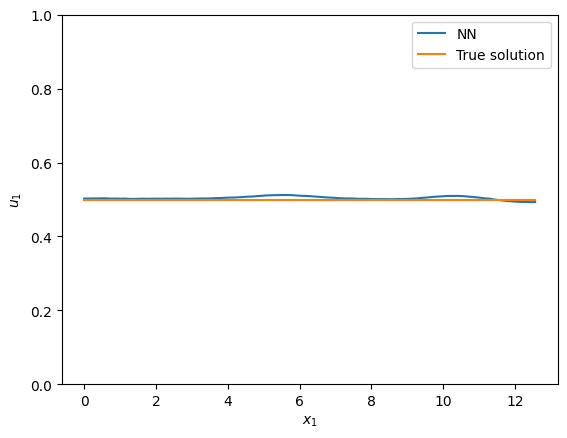

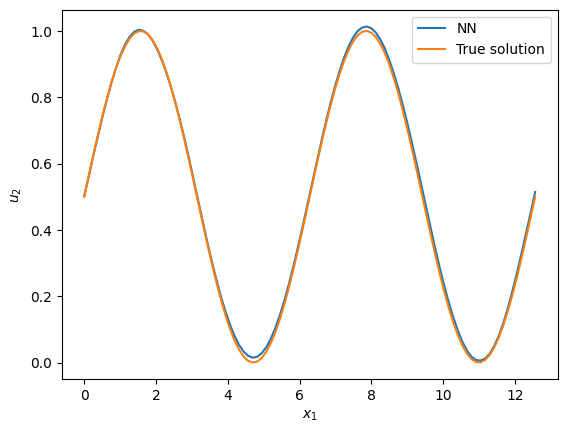

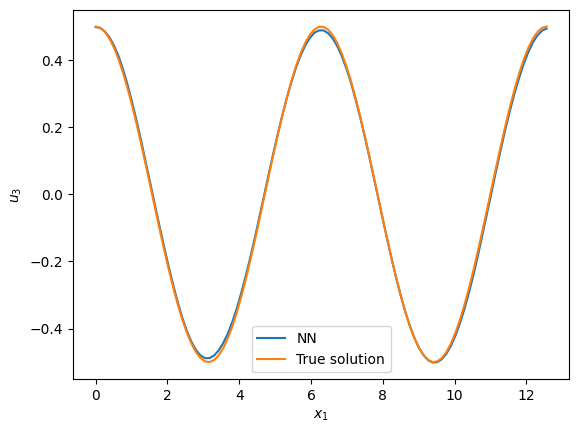

In [6]:
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*45+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu), exclude_terminal=True, ylim=(0, 1))

[Link to log directory:](logs/20220602-013139-abc_3d-T0.7-nu0.0002)

## 2-dimensional symmetric rotating flow
We use the terminal condition of
$$
\begin{cases}
\phi_0(x) &= \frac{f'(x_1)}{f(x_1)} \exp\left( -\frac{g(x_0)}{f(x_1)} \right),
\\
\phi_1(x) &= \frac{g'(x_0)}{g(x_0)} \exp\left( -\frac{g(x_0)}{f(x_1)} \right),
\end{cases}
$$
where
$x=(x_1,x_2) \in [-2,2]^2$,
$f(x) = \frac{1}{1+x^2}$,
and
$g(x) = 1 + x^2$.
It can be checked that the terminal condition satisfies the divergence free condition.

In [11]:
problem_name = "navier_stokes_rotating_flow"

def f(x):
    return 1 / (1 + x**2)

def fprime(x):
    return -2 * x / (1 + x**2)**2

def g(x):
    return 1 + x**2

def gprime(x):
    return 2 * x

t_lo, x_lo, x_hi = 0., -2, 2

# function definition
deriv_map = np.array(
    [
        [1, 0],  # for nabla p
        [0, 1],
        [0, 0],  # for u
        [0, 0],
        [1, 0],  # for nabla u1
        [0, 1],
        [1, 0],  # for nabla u2
        [0, 1],
    ]
)
zeta_map = np.array([-1, -1, 0, 1, 0, 0, 1, 1])
deriv_condition_deriv_map = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1])
_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return fprime(x[1]) / f(x[1]) * torch.exp(-g(x[0]) / f(x[1]))
    else:
        return gprime(x[0]) / g(x[0]) * torch.exp(-g(x[0]) / f(x[1]))

def plot_wall(model, nb_spatial, x_lo, x_hi):
    lw, delta = 5, 1e-1
    plt.axis('scaled')
    plt.xlim(x_lo, x_hi)
    plt.ylim(x_lo, x_hi)

def plot_quiver_and_color(model, tt, x_lo, x_hi, x1, x2, u, nb_spatial, vmin=None, vmax=None, plt_velocity=True):
    # for velocity, the magnitute is the length
    # for pressure, the magnitute is simply itself
    magnitute = torch.sqrt(u[0]**2 + u[1]**2) if plt_velocity else u[0]
    subject = "velocity" if plt_velocity else "pressure"
    f = plt.figure()
    s = f.add_subplot(1, 1, 1, xlabel='$x$', ylabel='$y$')
    cmap=cm.coolwarm
    im = s.imshow(
        magnitute.reshape(nb_spatial, nb_spatial),
        cmap=cmap,
        extent=(x_lo, x_hi, x_lo, x_hi),
        origin='lower',
        vmin=vmin,
        vmax=vmax,
    )
    f.colorbar(im)
    plot_wall(model, nb_spatial, x_lo, x_hi)
    
    if plt_velocity:
        # use coarser grid
        x1 = x1.reshape(nb_spatial, nb_spatial)[::5, ::5].reshape(-1)
        x2 = x2.reshape(nb_spatial, nb_spatial)[::5, ::5].reshape(-1)
        u = u.reshape(2, nb_spatial, nb_spatial)[:, ::5, ::5].reshape(2, -1)
        plt.quiver(x1, x2, u[0], u[1], scale=10*(vmax - vmin))
        plt.title(f"{subject} flow at t = {tt}")
    plt.title(f"{subject} flow at t = {tt}")
    f.savefig(f"{model.working_dir}/plot/t{tt}_{subject}.png", bbox_inches="tight", dpi=300)
    if isinstance(tt, numbers.Number) and (math.isclose(tt, model.t_lo) or math.isclose(tt, model.T)):
        plt.show()
    plt.close()

def plot_fluid(model, nb_time=21, nb_spatial=101, x_lo=None, x_hi=None):
    x_lo = model.x_lo if x_lo is None else x_lo
    x_hi = model.x_hi if x_hi is None else x_hi
    x1, x2 = np.meshgrid(
        np.linspace(x_lo, x_hi, nb_spatial + 2)[1:-1],
        np.linspace(x_lo, x_hi, nb_spatial + 2)[1:-1]
    )
    x1, x2 = x1.reshape(-1), x2.reshape(-1)
    time_arr = np.linspace(model.t_lo, model.T, nb_time)
    u = []
    for tt in time_arr:
        # create x
        x_tensor = torch.tensor(
            np.stack((tt * np.ones_like(x1), x1, x2)),
            device=model.device,
            dtype=torch.get_default_dtype()
        ).reshape(3, -1)
    
        # calculate u
        u.append(model(x_tensor.T, patch=0).T.detach().cpu())
    # merge all u together
    u = torch.stack(u, dim=0)
    
    # calculate terminal u & p
    terminal_u = torch.stack((
        model.phi_fun(x_tensor[1:], 0).cpu(),
        model.phi_fun(x_tensor[1:], 1).cpu(),
    ))
    p = model(x_tensor[1:].T, patch=0, p_or_u="p").T.detach().cpu()
    
    # plot
    magnitute = torch.sqrt(u[:, 0, :]**2 + u[:, 1, :]**2)
    magnitute = magnitute[~magnitute.isnan()]  # filter nan
    vmin, vmax = magnitute.min().item(), magnitute.max().item()
    for idx, tt in enumerate(time_arr):
        plot_quiver_and_color(model, tt, x_lo, x_hi, x1, x2, u[idx], nb_spatial, vmin, vmax)
    plot_quiver_and_color(model, "terminal", x_lo, x_hi, x1, x2, terminal_u, nb_spatial, vmin, vmax)
    plot_quiver_and_color(model, model.T, x_lo, x_hi, x1, x2, p, nb_spatial, plt_velocity=False)
    
    return x1, x2, u, p

Logs are saved in /home/nguwijy/repo/deep_branching_with_domain/logs/20220609-201837-navier_stokes_rotating_flow-T100-nu0.02
Patch 0: generation of p samples take 1505.5076336860657 seconds.
Patch  0: epoch    0 with loss 1.81E+00
Patch  0: epoch  500 with loss 4.17E-03
Patch  0: epoch 1000 with loss 3.93E-03
Patch  0: epoch 1500 with loss 3.40E-03
Patch  0: epoch 2000 with loss 2.36E-03
Patch  0: epoch 2500 with loss 1.29E-03
Patch  0: epoch 3000 with loss 5.61E-04
Patch  0: epoch 3500 with loss 2.06E-04
Patch  0: epoch 4000 with loss 9.83E-05
Patch  0: epoch 4500 with loss 1.17E-04
Patch  0: epoch 5000 with loss 4.31E-05
Patch  0: epoch 5500 with loss 3.22E-05
Patch  0: epoch 6000 with loss 2.54E-05
Patch  0: epoch 6500 with loss 1.15E-04
Patch  0: epoch 7000 with loss 2.47E-05
Patch  0: epoch 7500 with loss 1.33E-05
Patch  0: epoch 8000 with loss 1.11E-05
Patch  0: epoch 8500 with loss 2.66E-05
Patch  0: epoch 9000 with loss 7.84E-06
Patch  0: epoch 9500 with loss 8.09E-06
Patch  0:

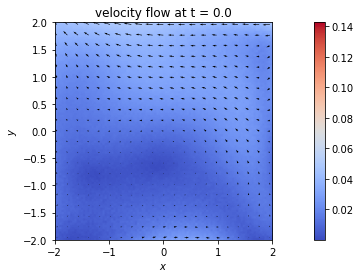

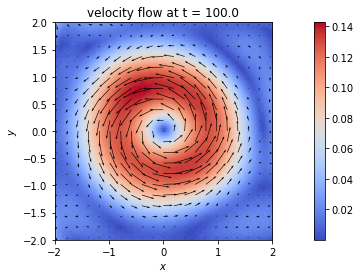

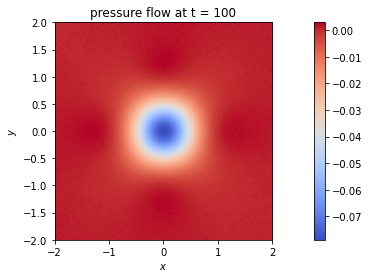

In [5]:
# use the trained model below
nu = .02
patches = 1
T = patches * 100

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,  # change to 100000
    branch_nb_states_per_batch=1000,
    epochs=10000,  # change to 10000
    fix_all_dim_except_first=False,
    fix_t_dim=False,  # change to False
    overtrain_rate=0.,
    outlier_multiplier=10,
    save_as_tmp=False,  # change to False
)
model.train_and_eval(debug_mode=False)
x1, x2, u, p = plot_fluid(model, nb_time=21) # change to 21

[Link to log directory:](logs/20220609-201837-navier_stokes_rotating_flow-T100-nu0.02)

Finally, we show the gif of simulated flow.
![velocity](logs/20220609-201837-navier_stokes_rotating_flow-T100-nu0.02/plot/velocity.gif "velocity")

## 2-dimensional asymmetric rotating flow
We use the terminal condition of
$$
\begin{cases}
\phi_0(x) &= \frac{f'(x_1)}{f(x_1)} \exp\left( -\frac{g(x_0)}{f(x_1)} \right),
\\
\phi_1(x) &= \frac{g'(x_0)}{g(x_0)} \exp\left( -\frac{g(x_0)}{f(x_1)} \right),
\end{cases}
$$
where
$x=(x_1,x_2) \in [-3,3]^2$,
$f(x) = \frac{2 + \sin(x)}{1+x^2}$,
and
$g(x) = \frac{e^{x^2}}{2 + x^3 + x^4}$.
It can be checked that the terminal condition satisfies the divergence free condition.

In [4]:
problem_name = "navier_stokes_rotating_flow"

def f(x):
    return (2 + torch.sin(x)) / (1 + x**2)

def fprime(x):
    return (
        ((1 + x**2) * torch.cos(x) - 2 * x * (2  + torch.sin(x)))
        / (1 + x**2)**2
    )

def g(x):
    return torch.exp(x**2) / (2 + x**3 + x**4)

def gprime(x):
    return (
        torch.exp(x**2) * x
        * (2 * x**4 + 2 * x**3 - 4 * x**2 - 3 * x + 4)
        / (2 + x**3 + x**4)**2
    )

t_lo, x_lo, x_hi = 0., -3, 3

# function definition
deriv_map = np.array(
    [
        [1, 0],  # for nabla p
        [0, 1],
        [0, 0],  # for u
        [0, 0],
        [1, 0],  # for nabla u1
        [0, 1],
        [1, 0],  # for nabla u2
        [0, 1],
    ]
)
zeta_map = np.array([-1, -1, 0, 1, 0, 0, 1, 1])
deriv_condition_deriv_map = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1])
_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return fprime(x[1]) / f(x[1]) * torch.exp(-g(x[0]) / f(x[1]))
    else:
        return gprime(x[0]) / g(x[0]) * torch.exp(-g(x[0]) / f(x[1]))

def plot_wall(model, nb_spatial, x_lo, x_hi):
    lw, delta = 5, 1e-1
    plt.axis('scaled')
    plt.xlim(x_lo, x_hi)
    plt.ylim(x_lo, x_hi)

def plot_quiver_and_color(model, tt, x_lo, x_hi, x1, x2, u, nb_spatial, vmin=None, vmax=None, plt_velocity=True):
    # for velocity, the magnitute is the length
    # for pressure, the magnitute is simply itself
    magnitute = torch.sqrt(u[0]**2 + u[1]**2) if plt_velocity else u[0]
    subject = "velocity" if plt_velocity else "pressure"
    f = plt.figure()
    s = f.add_subplot(1, 1, 1, xlabel='$x$', ylabel='$y$')
    cmap=cm.coolwarm
    im = s.imshow(
        magnitute.reshape(nb_spatial, nb_spatial),
        cmap=cmap,
        extent=(x_lo, x_hi, x_lo, x_hi),
        origin='lower',
        vmin=vmin,
        vmax=vmax,
    )
    f.colorbar(im)
    plot_wall(model, nb_spatial, x_lo, x_hi)
    
    if plt_velocity:
        # use coarser grid
        x1 = x1.reshape(nb_spatial, nb_spatial)[::5, ::5].reshape(-1)
        x2 = x2.reshape(nb_spatial, nb_spatial)[::5, ::5].reshape(-1)
        u = u.reshape(2, nb_spatial, nb_spatial)[:, ::5, ::5].reshape(2, -1)
        plt.quiver(x1, x2, u[0], u[1], scale=10*(vmax - vmin))
        plt.title(f"{subject} flow at t = {tt}")
    plt.title(f"{subject} flow at t = {tt}")
    f.savefig(f"{model.working_dir}/plot/t{tt}_{subject}.png", bbox_inches="tight", dpi=300)
    if isinstance(tt, numbers.Number) and (math.isclose(tt, model.t_lo) or math.isclose(tt, model.T)):
        plt.show()
    plt.close()

def plot_fluid(model, nb_time=21, nb_spatial=101, x_lo=None, x_hi=None):
    x_lo = model.x_lo if x_lo is None else x_lo
    x_hi = model.x_hi if x_hi is None else x_hi
    x1, x2 = np.meshgrid(
        np.linspace(x_lo, x_hi, nb_spatial + 2)[1:-1],
        np.linspace(x_lo, x_hi, nb_spatial + 2)[1:-1]
    )
    x1, x2 = x1.reshape(-1), x2.reshape(-1)
    time_arr = np.linspace(model.t_lo, model.T, nb_time)
    u = []
    for tt in time_arr:
        # create x
        x_tensor = torch.tensor(
            np.stack((tt * np.ones_like(x1), x1, x2)),
            device=model.device,
            dtype=torch.get_default_dtype()
        ).reshape(3, -1)
    
        # calculate u
        u.append(model(x_tensor.T, patch=0).T.detach().cpu())
    # merge all u together
    u = torch.stack(u, dim=0)
    
    # calculate terminal u & p
    terminal_u = torch.stack((
        model.phi_fun(x_tensor[1:], 0).cpu(),
        model.phi_fun(x_tensor[1:], 1).cpu(),
    ))
    p = model(x_tensor[1:].T, patch=0, p_or_u="p").T.detach().cpu()
    
    # plot
    magnitute = torch.sqrt(u[:, 0, :]**2 + u[:, 1, :]**2)
    magnitute = magnitute[~magnitute.isnan()]  # filter nan
    vmin, vmax = magnitute.min().item(), magnitute.max().item()
    for idx, tt in enumerate(time_arr):
        plot_quiver_and_color(model, tt, x_lo, x_hi, x1, x2, u[idx], nb_spatial, vmin, vmax)
    plot_quiver_and_color(model, "terminal", x_lo, x_hi, x1, x2, terminal_u, nb_spatial, vmin, vmax)
    plot_quiver_and_color(model, model.T, x_lo, x_hi, x1, x2, p, nb_spatial, plt_velocity=False)
    
    return x1, x2, u, p

In [ ]:
nu = .02
patches = 1
T = patches * 40

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,  # change to 100000
    branch_nb_states_per_batch=1000,
    epochs=10000,  # change to 10000
    fix_all_dim_except_first=False,
    fix_t_dim=False,  # change to False
    overtrain_rate=0.,
    outlier_multiplier=10,
    save_as_tmp=False,  # change to False
)
model.train_and_eval(debug_mode=False)
x1, x2, u, p = plot_fluid(model, nb_time=21) # change to 21

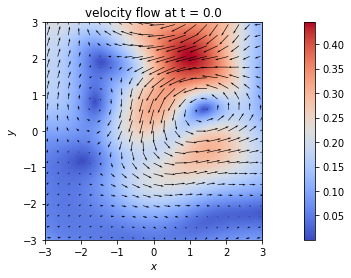

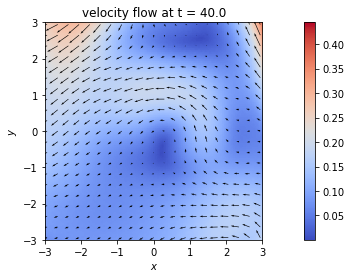

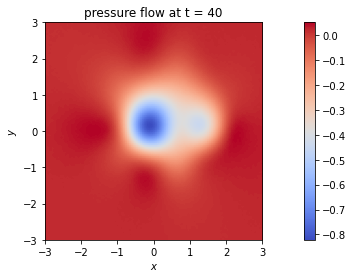

In [13]:
# I accidentally cleared the output of the cell above
# the training logs are not important and are available in the log directory
x1, x2, u, p = plot_fluid(model, nb_time=21) # change to 21

[Link to log directory:](logs/20220616-171714-navier_stokes_rotating_flow-T40-nu0.02)

Here, we see that the learned model is not consistent with the terminal condition, e.g. compare velocity flow at t = 40.0 with the following plot.<br>
<img src="logs/20220616-171714-navier_stokes_rotating_flow-T40-nu0.02/plot/tterminal_velocity.png" alt="terminal flow" width="300"/><br>
Since we impose divergence free condition during the training (`div_condition_coeff` default to be 1),
the model may sometimes find it difficult to balance all conditions.
Therefore, we try to relax such divergence free condition by letting `div_condition_coeff = 0`.

In [ ]:
# use the trained p above
nu = .02
patches = 1
T = patches * 40

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,  # change to 100000
    branch_nb_states_per_batch=1000,
    epochs=10000,  # change to 10000
    fix_all_dim_except_first=False,
    fix_t_dim=False,  # change to False
    overtrain_rate=0.,
    outlier_multiplier=10,
    save_as_tmp=False,  # change to False
    continue_from_checkpoint="logs/20220616-171714-navier_stokes_rotating_flow-T40-nu0.02",
    div_condition_coeff=0.,
)
model.train_and_eval(debug_mode=False)

[Link to log directory:](logs/20220616-232041-navier_stokes_rotating_flow-T40-nu0.02)

The high velocity at t = 0 makes the scaling unfit for studying the velocity at other times.
Using the same trained model, we next produce two plots of $t \in [5, 40]$ and $t \in [20, 40]$ respectively.

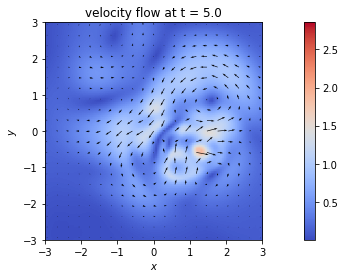

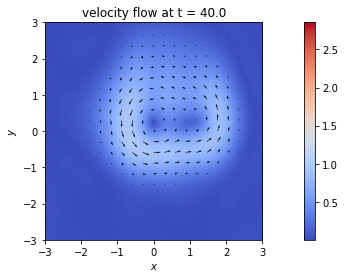

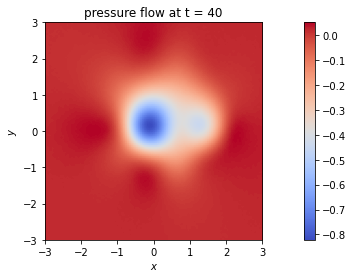

In [8]:
model.t_lo = 5
x1, x2, u, p = plot_fluid(model, nb_time=36)
model.t_lo = 0
!mkdir -p {model.working_dir + '/plot/5_to_40/'}
!mv {model.working_dir + '/plot/*png'} {model.working_dir + '/plot/5_to_40/'}

The velocity flow at t = 40.0 looks like similar the following terminal flow.<br>
<img src="logs/20220616-232041-navier_stokes_rotating_flow-T40-nu0.02/plot/5_to_40/tterminal_velocity.png" alt="terminal flow" width="300"/><br>

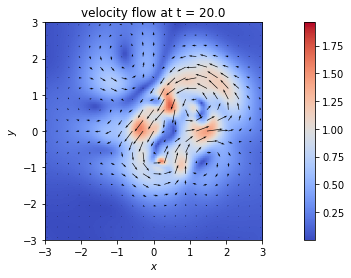

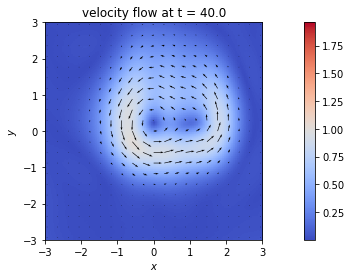

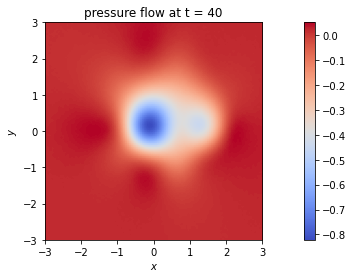

In [10]:
model.t_lo = 20
x1, x2, u, p = plot_fluid(model, nb_time=21)
model.t_lo = 0
!mkdir -p {model.working_dir + '/plot/20_to_40/'}
!mv {model.working_dir + '/plot/*png'} {model.working_dir + '/plot/20_to_40/'}

The velocity flow at t = 40.0 looks like similar the following terminal flow.<br>
<img src="logs/20220616-232041-navier_stokes_rotating_flow-T40-nu0.02/plot/20_to_40/tterminal_velocity.png" alt="terminal flow" width="300"/><br>
Next, we check if the learned model is free of divergence.

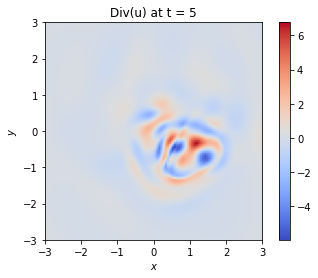

At time 5, the L2 loss of the divergence is 4.99E-01.


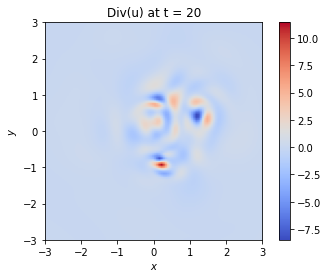

At time 20, the L2 loss of the divergence is 5.35E-01.


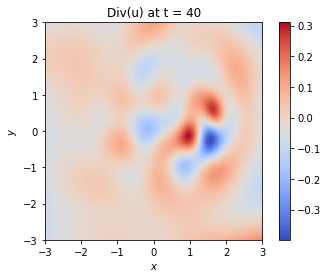

At time 40, the L2 loss of the divergence is 3.79E-03.


In [12]:
def check_divergence(model, t=0, nb_points=100, x_lo=None, x_hi=None):
    # create x
    x_lo = model.x_lo if x_lo is None else x_lo
    x_hi = model.x_hi if x_hi is None else x_hi
    x1, x2 = np.meshgrid(
        np.linspace(x_lo, x_hi, nb_points + 2)[1:-1],
        np.linspace(x_lo, x_hi, nb_points + 2)[1:-1]
    )
    x_tensor = torch.tensor(
        np.stack((t*np.ones_like(x1), x1, x2)),
        device=model.device,
        dtype=torch.get_default_dtype(),
        requires_grad=True,
    ).reshape(3, -1)
    
    grad = 0
    for (idx, c) in zip(model.deriv_condition_zeta_map, model.deriv_condition_deriv_map):
        # additional t coordinate
        grad += model.nth_derivatives(
            np.insert(c, 0, 0), model(x_tensor.T, patch=0)[:, idx], x_tensor
        )
    grad = grad.reshape(nb_points, nb_points).detach().cpu()

    # plot
    fig = plt.figure()
    s = fig.add_subplot(1, 1, 1, xlabel='$x$', ylabel='$y$')
    cmap=cm.coolwarm
    im = s.imshow(
        grad,
        cmap=cmap,
        extent=(model.x_lo, model.x_hi, model.x_lo, model.x_hi),
        origin='lower')
    fig.colorbar(im)
    plt.title(f"Div(u) at t = {t}")
    plt.show()
    plt.close()
    
    return grad

grad = check_divergence(model, t=5)
print(f"At time 5, the L2 loss of the divergence is {model.loss(grad, torch.zeros_like(grad)):.2E}.")
grad = check_divergence(model, t=20)
print(f"At time 20, the L2 loss of the divergence is {model.loss(grad, torch.zeros_like(grad)):.2E}.")
grad = check_divergence(model, t=T)
print(f"At time {T}, the L2 loss of the divergence is {model.loss(grad, torch.zeros_like(grad)):.2E}.")

The divergence is not zero, but is reasonably small.
Finally, we show the gif of simulated flow.
![velocity](logs/20220616-232041-navier_stokes_rotating_flow-T40-nu0.02/plot/5_to_40/velocity.gif "velocity")
![velocity](logs/20220616-232041-navier_stokes_rotating_flow-T40-nu0.02/plot/20_to_40/velocity.gif "velocity")